<a href="https://colab.research.google.com/github/apdaga/B6_GAAP_GCP/blob/main/code5_Langchain_and_Langgraph_Chains.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LangChain and LangGraph

In [40]:
!python -m pip install -U langchain langchain-core langchain-community langchain-experimental langchain-google-genai wikipedia --quiet

In [3]:
model_name='gemini-2.0-flash'

### Chatmodels, Prompt Templates and Parsers

In [4]:
import os
os.environ['GOOGLE_API_KEY']="<YOUR_GOOGLE_API_KEY>" # Key from "Google AI Studio"
os.environ['GOOGLE_GENAI_USE_VERTEXAI']="False" # Because we are not using Vertex AI key, we are using "Google AI Studio Key"
# os.environ['GOOGLE_CLOUD_LOCATION']="global"

In [5]:
from langchain.chat_models import init_chat_model
model = init_chat_model(model_name, model_provider="google_genai")

# use it as an LLM -> pass a prompt
prompt = "Write a poem about the city Bangalore"
response = model.invoke(prompt)
print(response.content)

A tapestry of green and chrome,
Bangalore awakens, far from home,
Yet welcomes all with open arms,
A city humming with a thousand charms.

From Vidhana Soudha, grand and white,
To Cubbon Park, bathed in morning light,
The fragrant jasmine scents the air,
A gentle breeze, beyond compare.

The honking horns, a rhythmic beat,
A constant pulse upon the street,
Where software giants rise and gleam,
And ancient temples softly dream.

The auto rickshaws weave and dart,
A vibrant chaos, a work of art,
While silk sarees shimmer, rich and bold,
Stories in their colours to be told.

From MG Road's bustling, vibrant scene,
To Koramangala, cool and serene,
The cafes buzz with youthful zest,
Innovations blooming, put to the test.

The lakes reflect the azure sky,
Where birdsong echoes, soaring high,
And Lal Bagh's gardens, lush and deep,
Secrets ancient, they gently keep.

But change is constant, ever near,
A modern marvel, banishing fear,
Yet holding onto roots so strong,
Where tradition lingers, a

In [6]:
# use it as a chatmodel - pass a chatprompt

from langchain_core.messages import HumanMessage

message = [HumanMessage(content="Hi How are you?")]
model.invoke(message)


AIMessage(content='I am doing well, thank you for asking! How are you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--f94eec87-350c-45ce-a232-926d713de447-0', usage_metadata={'input_tokens': 5, 'output_tokens': 16, 'total_tokens': 21, 'input_token_details': {'cache_read': 0}})

In [7]:
# chat prompt template
from langchain_core.prompts import ChatPromptTemplate

system_prompt = "Translate the following into the language {language}"
prompt_temp = ChatPromptTemplate([("system",system_prompt),("user","{text}")])
prompt_temp

ChatPromptTemplate(input_variables=['language', 'text'], input_types={}, partial_variables={}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['language'], input_types={}, partial_variables={}, template='Translate the following into the language {language}'), additional_kwargs={}), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['text'], input_types={}, partial_variables={}, template='{text}'), additional_kwargs={})])

In [8]:
prompt_temp.input_variables

['language', 'text']

In [9]:
myprompt = prompt_temp.invoke({"language":"French","text":"Hi How are you?"})
myprompt

ChatPromptValue(messages=[SystemMessage(content='Translate the following into the language French', additional_kwargs={}, response_metadata={}), HumanMessage(content='Hi How are you?', additional_kwargs={}, response_metadata={})])

In [10]:
op = model.invoke(myprompt)
op

AIMessage(content='Bonjour, comment allez-vous ?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--5e8dcc9f-5ffd-4021-aac6-f0e7a6c264ee-0', usage_metadata={'input_tokens': 12, 'output_tokens': 8, 'total_tokens': 20, 'input_token_details': {'cache_read': 0}})

In [11]:
from langchain_core.output_parsers import StrOutputParser
parser = StrOutputParser()
parser.invoke(op)

'Bonjour, comment allez-vous ?'

In [12]:
op.content

'Bonjour, comment allez-vous ?'

## Automation using Chains: Automations / Automation Flows / Chains / Chain Workflows
- static workflows involving LLMs inbetween the steps,
- the flow of data, steps are deterministic, decided by the developer/SME

**Example**

Language Translation Chain: input -----> [Prompt Templates >> LLM >> Parser ]----> Output

In [13]:
# chat prompt template
from langchain_core.prompts import ChatPromptTemplate
system_prompt = "Translate the following into the language {language}"
prompt_temp = ChatPromptTemplate([("system",system_prompt),("user","{text}")])


from langchain.chat_models import init_chat_model
model = init_chat_model(model_name, model_provider="google_genai")


from langchain_core.output_parsers import StrOutputParser
parser = StrOutputParser()

In [14]:
# implement a chain using langchain
chain1 = prompt_temp | model | parser

chain1.invoke({"language":"telugu","text":"WHAT IS YOUR NAME?"})

'నీ పేరేమిటి? (Nee peremiti?)'

In [15]:
def format_output(text):
    return {"Translation":text}

In [16]:
# implement a chain using langchain
chain1 = prompt_temp | model | parser | format_output

chain1.invoke({"language":"telugu","text":"WHAT IS YOUR NAME?"})

{'Translation': 'నీ పేరు ఏమిటి? (Nee peru emiti?)'}

#### Code Chain

In [17]:
# Code generation chain
generate_prompt = ChatPromptTemplate([("system","Write a simple code for the task, only provide code no other additional text"),
                                      ("user","{task}")])

generation_chain = generate_prompt | model | parser

op = generation_chain.invoke("fibonacci series")
print(op)

```python
def fibonacci(n):
  """
  Generates the Fibonacci sequence up to n terms.

  Args:
    n: The number of terms to generate.

  Returns:
    A list containing the Fibonacci sequence up to n terms.
  """
  if n <= 0:
    return []
  elif n == 1:
    return [0]
  else:
    list_fib = [0, 1]
    while len(list_fib) < n:
      next_fib = list_fib[-1] + list_fib[-2]
      list_fib.append(next_fib)
    return list_fib

if __name__ == '__main__':
  num_terms = 10
  fib_sequence = fibonacci(num_terms)
  print(f"Fibonacci sequence up to {num_terms} terms: {fib_sequence}")
```


In [18]:
analyze_prompt = ChatPromptTemplate([("system","Analyze the provided code, add docstrings and comments. only provide code no other additional text"),
                                      ("user","{code}")])

analyze_chain = analyze_prompt | model | parser
print(analyze_chain.invoke({"code":op}))

```python
def fibonacci(n):
  """
  Generates the Fibonacci sequence up to n terms.

  Args:
    n: The number of terms to generate.

  Returns:
    A list containing the Fibonacci sequence up to n terms.
  """
  if n <= 0:
    return []  # Return an empty list if n is zero or negative
  elif n == 1:
    return [0]  # Return a list with only 0 if n is 1
  else:
    list_fib = [0, 1]  # Initialize the list with the first two Fibonacci numbers
    while len(list_fib) < n:
      next_fib = list_fib[-1] + list_fib[-2]  # Calculate the next Fibonacci number
      list_fib.append(next_fib)  # Add the next Fibonacci number to the list
    return list_fib  # Return the complete Fibonacci sequence

if __name__ == '__main__':
  num_terms = 10  # Define the number of Fibonacci terms to generate
  fib_sequence = fibonacci(num_terms)  # Generate the Fibonacci sequence
  print(f"Fibonacci sequence up to {num_terms} terms: {fib_sequence}")  # Print the generated sequence
```


In [19]:
def patch_inputs (code):
    return {"code":code}

final_chain = generation_chain | patch_inputs | analyze_chain
op = final_chain.invoke({"task":"fibonacci series"})
print(op)

```python
def fibonacci(n):
  """
  Generates the Fibonacci sequence up to n terms.

  Args:
    n: The number of terms in the sequence.

  Returns:
    A list containing the Fibonacci sequence.
  """
  if n <= 0:
    return []  # Return an empty list if n is non-positive
  elif n == 1:
    return [0]  # Return a list with only 0 if n is 1
  else:
    list_fib = [0, 1]  # Initialize the list with the first two Fibonacci numbers
    while len(list_fib) < n:
      next_fib = list_fib[-1] + list_fib[-2]  # Calculate the next Fibonacci number
      list_fib.append(next_fib)  # Add the next Fibonacci number to the list
    return list_fib  # Return the Fibonacci sequence

if __name__ == '__main__':
  num_terms = 10  # Define the number of terms to generate
  fib_sequence = fibonacci(num_terms)  # Generate the Fibonacci sequence
  print(f"Fibonacci sequence up to {num_terms} terms: {fib_sequence}")  # Print the generated sequence
```


In [26]:
final_chain = generate_prompt | model | parser | patch_inputs | analyze_prompt | model | parser
op = final_chain.invoke({"task":"fibonacci series"})
print(op)

```python
def fibonacci(n):
  """
  Generates the Fibonacci sequence up to n terms.

  Args:
    n: The number of terms to generate.

  Returns:
    A list containing the Fibonacci sequence.
  """
  if n <= 0:
    return []  # Return an empty list if n is not positive
  elif n == 1:
    return [0]  # Return a list with only 0 if n is 1
  else:
    list_fib = [0, 1]  # Initialize the list with the first two Fibonacci numbers
    while len(list_fib) < n:
      next_fib = list_fib[-1] + list_fib[-2]  # Calculate the next Fibonacci number
      list_fib.append(next_fib)  # Add the next Fibonacci number to the list
    return list_fib  # Return the list of Fibonacci numbers

if __name__ == '__main__':
  num_terms = 10  # Define the number of terms to generate
  fib_sequence = fibonacci(num_terms)  # Generate the Fibonacci sequence
  print(f"Fibonacci sequence up to {num_terms} terms: {fib_sequence}")  # Print the sequence
```


### Tools with Langchain

In [27]:
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

wiki = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(top_k_results=2))

wiki.invoke("Artificial Intelligence")

'Page: Artificial intelligence\nSummary: Artificial intelligence (AI) is the capability of computational systems to perform tasks typically associated with human intelligence, such as learning, reasoning, problem-solving, perception, and decision-making. It is a field of research in computer science that develops and studies methods and software that enable machines to perceive their environment and use learning and intelligence to take actions that maximize their chances of achieving defined goals.\nHigh-profile applications of AI include advanced web search engines (e.g., Google Search); recommendation systems (used by YouTube, Amazon, and Netflix); virtual assistants (e.g., Google Assistant, Siri, and Alexa); autonomous vehicles (e.g., Waymo); generative and creative tools (e.g., language models and AI art); and superhuman play and analysis in strategy games (e.g., chess and Go). However, many AI applications are not perceived as AI: "A lot of cutting edge AI has filtered into gener

In [28]:
print(wiki.name)
print(wiki.description)
print(wiki.args)

wikipedia
A wrapper around Wikipedia. Useful for when you need to answer general questions about people, places, companies, facts, historical events, or other subjects. Input should be a search query.
{'query': {'description': 'query to look up on wikipedia', 'title': 'Query', 'type': 'string'}}


In [29]:
search_prompt = ChatPromptTemplate.from_template("generate a query to be searched on wikipedia for a given user inputs {input} . keep it short")

chain = search_prompt | model | parser | wiki | parser

chain.invoke({"input":"I am interested in world war II"})

"Page: World War II\nSummary: World War II or the Second World War (1 September 1939 – 2 September 1945) was a global conflict between two coalitions: the Allies and the Axis powers. Nearly all of the world's countries participated, with many nations mobilising all resources in pursuit of total war. Tanks and aircraft played major roles, enabling the strategic bombing of cities and delivery of the first and only nuclear weapons ever used in war. World War II is the deadliest conflict in history, causing the death of 70 to 85 million people, more than half of whom were civilians. Millions died in genocides, including the Holocaust, and by massacres, starvation, and disease. After the Allied victory, Germany, Austria, Japan, and Korea were occupied, and German and Japanese leaders were tried for war crimes.\nThe causes of World War II included unresolved tensions in the aftermath of World War I, the rise of fascism in Europe and militarism in Japan. Key events preceding the war included 

## Getting started with LangGraph

- compatiable with langchain tools: langchain, langsmith, langfuse, openai
- represent codes/functions/code_blocks as nodes and represent interactions as connections in graph



Key components

- Node: individual step/action (a function which makes llm call)
- Edges: connection between nodes, define the exection flow between nodes
- Graph: collection of nodes and edges, a complete structures
- State: a shared data structure followed by all nodes and connections ( a common schema)

In [30]:
!python -m pip install langgraph --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.3/208.3 kB 10.1 MB/s eta 0:00:00


In [31]:
from dotenv import load_dotenv
load_dotenv()

False

In [35]:
# initiate a state

from typing import TypedDict

class myState(TypedDict):
    query:str
    response:str


In [39]:
# create a node


from langchain_core.prompts import PromptTemplate
from langchain.chat_models import init_chat_model
model = init_chat_model(model_name, model_provider="google_genai")


# define a node: a node will alwaystake state (myState) as input and return state variables as output
def assistant(state:myState)->myState:
    prompt = PromptTemplate(input_variables=["query"],
                            template="Anwer the question in concise way {query}")

    chain = prompt | model | parser
    response= chain.invoke({"query":state['query']})
    #response = model.invoke(prompt.format(query=state['query'])).content
    return {"response":response}


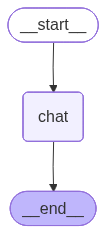

In [41]:
# build graph
from langgraph.graph import StateGraph,START,END

builder = StateGraph(myState)
builder.add_node("chat",assistant)
builder.add_edge(START,"chat")
builder.add_edge("chat",END)

graph = builder.compile()
graph

In [42]:
result = graph.invoke({"query":"What is capital of Canada?"})
print(result)

{'query': 'What is capital of Canada?', 'response': 'Ottawa'}


In [43]:
print(result['response'])

Ottawa


In [44]:
class myState(TypedDict):
    query:str
    response:str
    valid:bool

In [45]:
# adding an additional node: validting the input

# adding a node: checker which checks the input and validates based on certain rules
def checker(state:myState)->myState:
    if len(state['query'].strip())<10:
        return {"valid":False,"response":"ENTER A VALID QUESTION"}
    else:
        return {"valid":True}

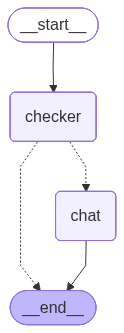

In [46]:
builder = StateGraph(myState)

builder.add_node("checker",checker)
builder.add_node("chat",assistant)

# add connection
builder.add_edge(START,"checker")


# add a conditional edge
def route(state:myState):
    if state['valid']:
        return "chat"
    else:
        return END

builder.add_conditional_edges("checker",route,{"chat":"chat",END:END})
builder.add_edge("chat",END)


graph = builder.compile()
graph

In [47]:
result = graph.invoke({"query":"what is capital of France?"})
print(result)

{'query': 'what is capital of France?', 'response': 'Paris', 'valid': True}


In [48]:
result = graph.invoke({"query":"what ?       "})
print(result)

{'query': 'what ?       ', 'response': 'ENTER A VALID QUESTION', 'valid': False}


## Code Chain

- Generate code, analyze code

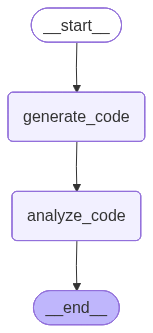

In [49]:
from typing import TypedDict
from langchain_core.prompts import ChatPromptTemplate
from langchain.chat_models import init_chat_model
model = init_chat_model(model_name, model_provider="google_genai")

class simpleState(TypedDict):
    code:str
    task:str
    modified_code:str


def generate_code(state:simpleState)->simpleState:
    generate_prompt = ChatPromptTemplate([("system","Write a simple code for the task, only provide code no other additional text"),
                                      ("user","{task}")])
    code = model.invoke(generate_prompt.invoke({"task":state["task"]})).content
    return {"code":code}


def analyze_code(state:simpleState)->simpleState:
    analyze_prompt = ChatPromptTemplate([("system","Analyze the provided code, add docstrings and comments. only provide code no other additional text"),
                                      ("user","{code}")])
    modified_code = model.invoke(analyze_prompt.invoke({"code":state["code"]})).content
    return {"modified_code":modified_code}


builder = StateGraph(simpleState)
builder.add_sequence([generate_code,analyze_code])
builder.add_edge(START,"generate_code")

graph = builder.compile()
graph



In [50]:
result = graph.invoke({"task":"FIBONACCI SERIES"})

In [51]:
print(result)

{'code': '```python\ndef fibonacci(n):\n    """\n    Generates the Fibonacci sequence up to n terms.\n\n    Args:\n        n: The number of terms to generate.\n\n    Returns:\n        A list containing the Fibonacci sequence up to n terms.\n    """\n    if n <= 0:\n        return []\n    elif n == 1:\n        return [0]\n    else:\n        list_fib = [0, 1]\n        while len(list_fib) < n:\n            next_fib = list_fib[-1] + list_fib[-2]\n            list_fib.append(next_fib)\n        return list_fib\n\nif __name__ == \'__main__\':\n    num_terms = int(input("Enter the number of Fibonacci terms to generate: "))\n    fib_sequence = fibonacci(num_terms)\n    print("Fibonacci Sequence:", fib_sequence)\n```', 'task': 'FIBONACCI SERIES', 'modified_code': '```python\ndef fibonacci(n):\n    """\n    Generates the Fibonacci sequence up to n terms.\n\n    Args:\n        n: The number of terms to generate.\n\n    Returns:\n        A list containing the Fibonacci sequence up to n terms.\n    

In [52]:
print(result['code'])

```python
def fibonacci(n):
    """
    Generates the Fibonacci sequence up to n terms.

    Args:
        n: The number of terms to generate.

    Returns:
        A list containing the Fibonacci sequence up to n terms.
    """
    if n <= 0:
        return []
    elif n == 1:
        return [0]
    else:
        list_fib = [0, 1]
        while len(list_fib) < n:
            next_fib = list_fib[-1] + list_fib[-2]
            list_fib.append(next_fib)
        return list_fib

if __name__ == '__main__':
    num_terms = int(input("Enter the number of Fibonacci terms to generate: "))
    fib_sequence = fibonacci(num_terms)
    print("Fibonacci Sequence:", fib_sequence)
```


In [53]:
print(result['modified_code'])

```python
def fibonacci(n):
    """
    Generates the Fibonacci sequence up to n terms.

    Args:
        n: The number of terms to generate.

    Returns:
        A list containing the Fibonacci sequence up to n terms.
    """
    if n <= 0:
        return []  # Return an empty list if n is non-positive
    elif n == 1:
        return [0]  # Return a list with only 0 if n is 1
    else:
        list_fib = [0, 1]  # Initialize the list with the first two Fibonacci numbers
        while len(list_fib) < n:
            next_fib = list_fib[-1] + list_fib[-2]  # Calculate the next Fibonacci number
            list_fib.append(next_fib)  # Add the next Fibonacci number to the list
        return list_fib  # Return the generated Fibonacci sequence

if __name__ == '__main__':
    num_terms = int(input("Enter the number of Fibonacci terms to generate: "))  # Prompt the user for the number of terms
    fib_sequence = fibonacci(num_terms)  # Generate the Fibonacci sequence
    print("Fibonacci Se